## Introduction 
Gaussian process regression (GP prior and Gaussian likelihood) can be solved in closed form, since the posterior is also a Gaussian. Below we can write some numpy to yield posterior predictions at new data points (without performing hyper-parameter optimization

In [238]:
import altair as alt
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [5]:
# Let's make some training data
x_train = np.linspace(0,1,100)
y_train = np.sin(x_train*(2*np.pi)) + 0.2*np.random.normal(size=x_train.shape)

In [10]:
np.alltrue((1,2) == (0,2))

False

In [12]:
def kernel_rbf(x, y, var=0.2, length_scale=1.):
    assert isinstance(x, np.ndarray), "Inputs should be nd arrays"
    assert np.all(x.shape == y.shape), 'x and y have different dimensions'
    return var*np.exp(-(np.sum(np.power(x-y, 2))/(2*length_scale**2)))

In [213]:
kernel_rbf_full(np.array([1,0]), np.array([1,0]))

array([[1.00000000e+00, 1.49453385e-05],
       [1.49453385e-05, 1.00000000e+00]])

In [212]:
# Let's use numpy magic to make the full covariance matrix at once!
def kernel_rbf_full(x, y, length_scale=0.3):
    assert isinstance(x, np.ndarray), "Inputs should be nd arrays"
#     assert np.all(x.shape == y.shape), 'x and y have different dimensions'
    return np.exp(-np.power(np.subtract.outer(x,y)/length_scale,2))

Let's work by defining the conditional distribution. This is the distribution of y values, given we've seen some other x and y values.

In [274]:
#def conditional(x_new, x, y, covariance_function, sigma_obs = 0.3):
x = np.linspace(-1,1,100)
f_true = lambda x: np.sin(x*(2*np.pi))
y_true = f_true(x)
f_obs = lambda x: np.sin(x*(2*np.pi)) + 0.2*np.random.normal(size=x.shape)
y_obs = f_obs(x)

def gp_conditional(x_new, x, y, cov_function, sigma_obs = 0.3):
    """Returns sthe predictive mean and variance at some new locations"""
    K = cov_function(x, x)
    K += sigma_obs*np.eye(N=K.shape[0])
    L = scipy.linalg.cholesky(K, lower=True)
    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y, lower=True))
    k_star = cov_function(x, x_new)
    f = k_star.T@alpha

    v = scipy.linalg.solve_triangular(L, k_star, lower=True)
    f_var = cov_function(x_new, x_new) - v.T@v
    n = x.shape[0]
    lml = -0.5*y.T@alpha - n*np.log(2*np.pi)/2 - np.sum(np.log(np.diag(L)))
    return f, f_var, lml

In [334]:
domain_ = ['observed', 'truth', 'posterior', 'sample']
range_ = ['red', 'black', 'green', 'blue']

def plot_numpy_samples(x, numpy_samples, max_samples = 50):
    samples, points = numpy_samples.shape
    samples_to_plot = numpy_samples
    idx = np.random.choice(np.arange(samples), size = np.minimum(samples, max_samples), replace=False)
    raw_samples = pd.DataFrame(samples_to_plot[idx,:].T)
    raw_samples.columns = ['sample_%d'%col for col in raw_samples.columns]
    raw_samples['x'] = x
    samples_plot = pd.melt(raw_samples, id_vars='x', var_name='sample_id')
    samples_plot['label'] = 'sample'
    
    prior_samples = alt.Chart(samples_plot).mark_line().encode(x='x', y='value', detail='sample_id',
                                                              color=alt.Color('label', title='Legend', scale=alt.Scale(domain=domain_,
                                                                                 range=range_)))
    return prior_samples.interactive()

In [240]:
x_new = np.array([0.3, -0.5])
mu_star, sigma_star, _ = gp_conditional(x_new, x, y, kernel_rbf_full)

In [241]:
mu_star

array([0.93841753, 0.07739001])

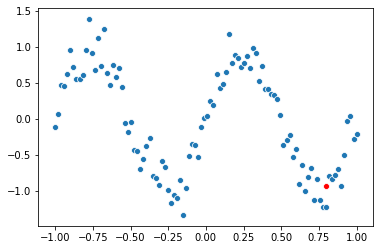

In [235]:
sns.scatterplot(x, y)
sns.scatterplot(x_new, f_bar_star, color='red')

- Draw many samples from a given kernel
- Condition on a couple of samples
- x_new is many other points

In [310]:
# Prior samples
n_points = 100
x_coords = np.linspace(-1,1,n_points)
numpy_samples = scipy.stats.multivariate_normal(mean = np.zeros(n_points), 
                                                cov = kernel_rbf_full(x_coords, x_coords),
                                               allow_singular=True).rvs(size=15)
plot_numpy_samples(x_coords,numpy_samples)

alt.Chart(...)

In [339]:
# observe a few points
x_obs = np.array([-0.4, 0.8, -0.44, 0.7, 0, 0.01])
y_obs = f_obs(x_obs)
f_star, f_sigma_star = gp_conditional(x_coords, x_obs, y_obs, kernel_rbf_full, sigma_obs=0.05)
conditional_samples = scipy.stats.multivariate_normal(mean = f_star,
                                                     cov = f_sigma_star,
                                                     allow_singular=True).rvs(size=200)
conditional_samples_plot = plot_numpy_samples(x_coords, conditional_samples).mark_line(opacity=0.2)
domain_ = ['observed', 'truth', 'posterior', 'sample']
range_ = ['red', 'black', 'green', 'blue']
observed_plot = alt.Chart(pd.DataFrame({'x':x_obs,
                                          'value':y_obs,
                                       'label':'observed'})).mark_circle(size=100).encode(x='x',y='value',color=alt.Color('label', scale=alt.Scale(domain=domain_,
                                                                                 range=range_)))
true_chart = alt.Chart(pd.DataFrame({'x':x_coords,
                                    'value':y_true,
                                    'label':'truth'})).mark_line().encode(x='x',y='value',color=alt.Color('label', scale=alt.Scale(domain=domain_,
                                                                                 range=range_)))
posterior_chart = alt.Chart(pd.DataFrame({'x':x_coords,
                                        'value':f_star,
                                         'label':'posterior'})).mark_line().encode(x='x',y='value',color=alt.Color('label', scale=alt.Scale(domain=domain_,
                                                                                 range=range_)))
alt.layer(conditional_samples_plot, observed_plot, 
          true_chart, posterior_chart)

alt.LayerChart(...)

In [322]:
?alt.Color